# Baseline Model - DummyClassifier


The Dummy Classifier serves as a crucial benchmark tool. It provides a minimal baseline to evaluate whether more sophisticated models are genuinely improving over simple, non-learning approaches like random predictions or those based on class distributions.

## 1. Import Libraries


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
import json
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')

from evaluate import (
    evaluate_model, 
    compare_models, 
    print_comparison_table,
    save_evaluation_results,
    get_classification_report,
    get_confusion_matrix
)
from visualize import (
    plot_confusion_matrix,
    plot_metrics_comparison
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" All libraries imported successfully")

 All libraries imported successfully


## 2. Load Processed Data



In [4]:
X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

with open('../data/processed/config.json', 'r') as f:
    config = json.load(f)

train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print("DATASET INFORMATION")
print(f"Training sequences shape: {X_train.shape}")
print(f"Test sequences shape:     {X_test.shape}")
print(f"Training labels shape:    {y_train.shape}")
print(f"Test labels shape:        {y_test.shape}")
print(f"\nVocabulary size: {config['vocab_size']}")
print(f"Max sequence length: {config['max_len']}")

print(f"\n{'Class Distribution in Training Set':^60}")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for label, count in zip(unique_train, counts_train):
    label_name = 'Positive' if label == 1 else 'Negative'
    percentage = (count / len(y_train)) * 100
    print(f"{label_name:>10s} ({label}): {count:>5d} ({percentage:>5.2f}%)")

print(f"\n{'Class Distribution in Test Set':^60}")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for label, count in zip(unique_test, counts_test):
    label_name = 'Positive' if label == 1 else 'Negative'
    percentage = (count / len(y_test)) * 100
    print(f"{label_name:>10s} ({label}): {count:>5d} ({percentage:>5.2f}%)")

if 'source' in train_df.columns:
    print(f"\n{'Source Distribution':^60}")
    print(train_df['source'].value_counts())

print(f"\n Data loaded successfully")

DATASET INFORMATION
Training sequences shape: (2400, 100)
Test sequences shape:     (600, 100)
Training labels shape:    (2400,)
Test labels shape:        (600,)

Vocabulary size: 4632
Max sequence length: 100

             Class Distribution in Training Set             
  Negative (0):  1200 (50.00%)
  Positive (1):  1200 (50.00%)

               Class Distribution in Test Set               
  Negative (0):   300 (50.00%)
  Positive (1):   300 (50.00%)

                    Source Distribution                     
source
amazon    816
imdb      808
yelp      776
Name: count, dtype: int64

 Data loaded successfully


## 3. Implement DummyClassifier Strategies

We will test different strategies:
- **most_frequent**: Always predicts the most frequent class in training set
- **stratified**: Predicts classes based on training set class distribution
- **uniform**: Predicts classes uniformly at random


In [5]:
strategies = ['most_frequent', 'stratified', 'uniform', 'constant']
baseline_models = {}
baseline_results = {}

print("TRAINING BASELINE MODELS")

for strategy in strategies:
    print(f"\n>>> Training {strategy.upper()} strategy...")
    
    if strategy == 'constant':
        dummy_clf = DummyClassifier(strategy=strategy, constant=1, random_state=42)
    else:
        dummy_clf = DummyClassifier(strategy=strategy, random_state=42)
    
    dummy_clf.fit(X_train, y_train)
    
    baseline_models[f'Baseline_{strategy}'] = dummy_clf
    
    print(f" {strategy} model trained")

print("ALL BASELINE MODELS TRAINED")


TRAINING BASELINE MODELS

>>> Training MOST_FREQUENT strategy...
 most_frequent model trained

>>> Training STRATIFIED strategy...
 stratified model trained

>>> Training UNIFORM strategy...
 uniform model trained

>>> Training CONSTANT strategy...
 constant model trained
ALL BASELINE MODELS TRAINED


## 4. Evaluate All Baseline Models

In [6]:
print("EVALUATING BASELINE MODELS")

for model_name, model in baseline_models.items():
    print(f"Evaluating: {model_name}")
    
    y_pred = model.predict(X_test)
    
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    except:
        y_pred_proba = y_pred.astype(float)
    
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, 
        f1_score, cohen_kappa_score
    )
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'cohen_kappa': cohen_kappa_score(y_test, y_pred),
    }
    
    
    baseline_results[model_name] = {
        'metrics': metrics,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': get_confusion_matrix(y_test, y_pred),
        'classification_report': get_classification_report(y_test, y_pred, verbose=0)
    }
    
    print(f"\nPerformance Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name.replace('_', ' ').title():<20s}: {value:.4f}")
    
    print(f"\n{get_classification_report(y_test, y_pred, verbose=0)}")
    
    unique, counts = np.unique(y_pred, return_counts=True)
    pred_dist = dict(zip(unique, counts))
    print(f"\n{'Prediction Distribution':-^40}")
    for label in [0, 1]:
        label_name = 'Positive' if label == 1 else 'Negative'
        count = pred_dist.get(label, 0)
        percentage = (count / len(y_pred)) * 100
        print(f"{label_name:>10s} ({label}): {count:>5d} ({percentage:>5.2f}%)")

print("BASELINE EVALUATION COMPLETE")


EVALUATING BASELINE MODELS
Evaluating: Baseline_most_frequent

Performance Metrics:
Accuracy            : 0.5000
Precision           : 0.0000
Recall              : 0.0000
F1 Score            : 0.0000
Cohen Kappa         : 0.0000

              precision    recall  f1-score   support

    Negative     0.5000    1.0000    0.6667       300
    Positive     0.0000    0.0000    0.0000       300

    accuracy                         0.5000       600
   macro avg     0.2500    0.5000    0.3333       600
weighted avg     0.2500    0.5000    0.3333       600


--------Prediction Distribution---------
  Negative (0):   600 (100.00%)
  Positive (1):     0 ( 0.00%)
Evaluating: Baseline_stratified

Performance Metrics:
Accuracy            : 0.5200
Precision           : 0.5208
Recall              : 0.5000
F1 Score            : 0.5102
Cohen Kappa         : 0.0400

              precision    recall  f1-score   support

    Negative     0.5192    0.5400    0.5294       300
    Positive     0.5208    0.

## 5. Compare All Baseline Strategies



In [7]:
comparison_df = compare_models(
    baseline_results, 
    save_path='../outputs/metrics/baseline_comparison.csv'
)

print_comparison_table(comparison_df)

from evaluate import get_best_model
best_model_name, best_f1 = get_best_model(baseline_results, metric='f1_score')

print(f"\n Best Baseline Model: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")



Comparison saved to: ../outputs/metrics/baseline_comparison.csv
MODEL COMPARISON
                 Model  accuracy  precision  recall  f1_score  cohen_kappa
   Baseline_stratified      0.52   0.520833    0.50  0.510204         0.04
      Baseline_uniform      0.51   0.509615    0.53  0.519608         0.02
Baseline_most_frequent      0.50   0.000000    0.00  0.000000         0.00
     Baseline_constant      0.50   0.500000    1.00  0.666667         0.00

 Best Baseline Model: Baseline_constant
   F1-Score: 0.6667


## 6. Visualize Metrics Comparison

Metrics comparison saved to: ../outputs/figures/baseline_comparison.png


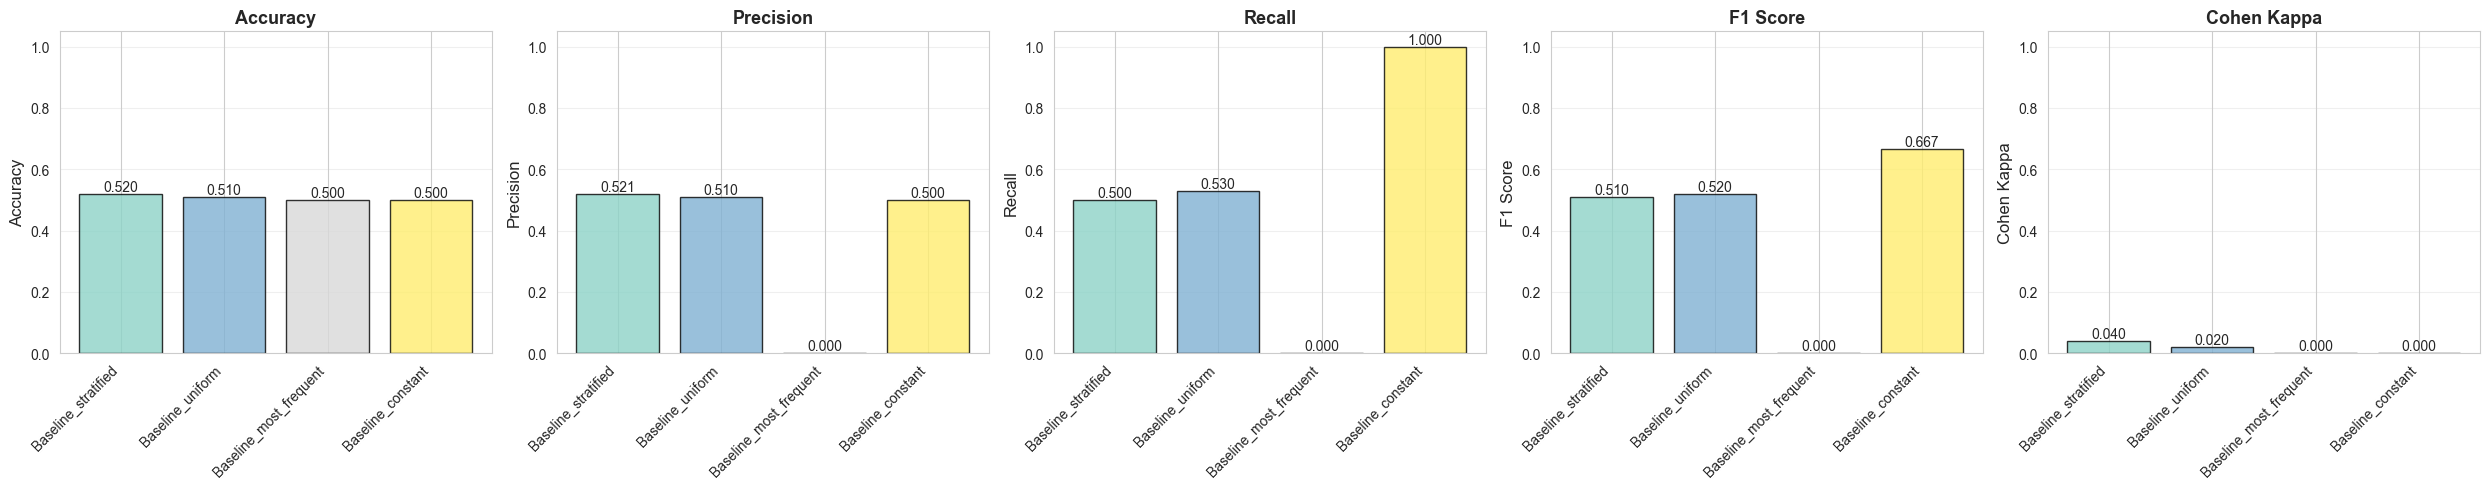

In [8]:
plot_metrics_comparison(
    comparison_df,
    save_path='../outputs/figures/baseline_comparison.png'
)


## 7. Confusion Matrices for All Models


✓ Figure saved: outputs/figures/baseline_confusion_matrices.png


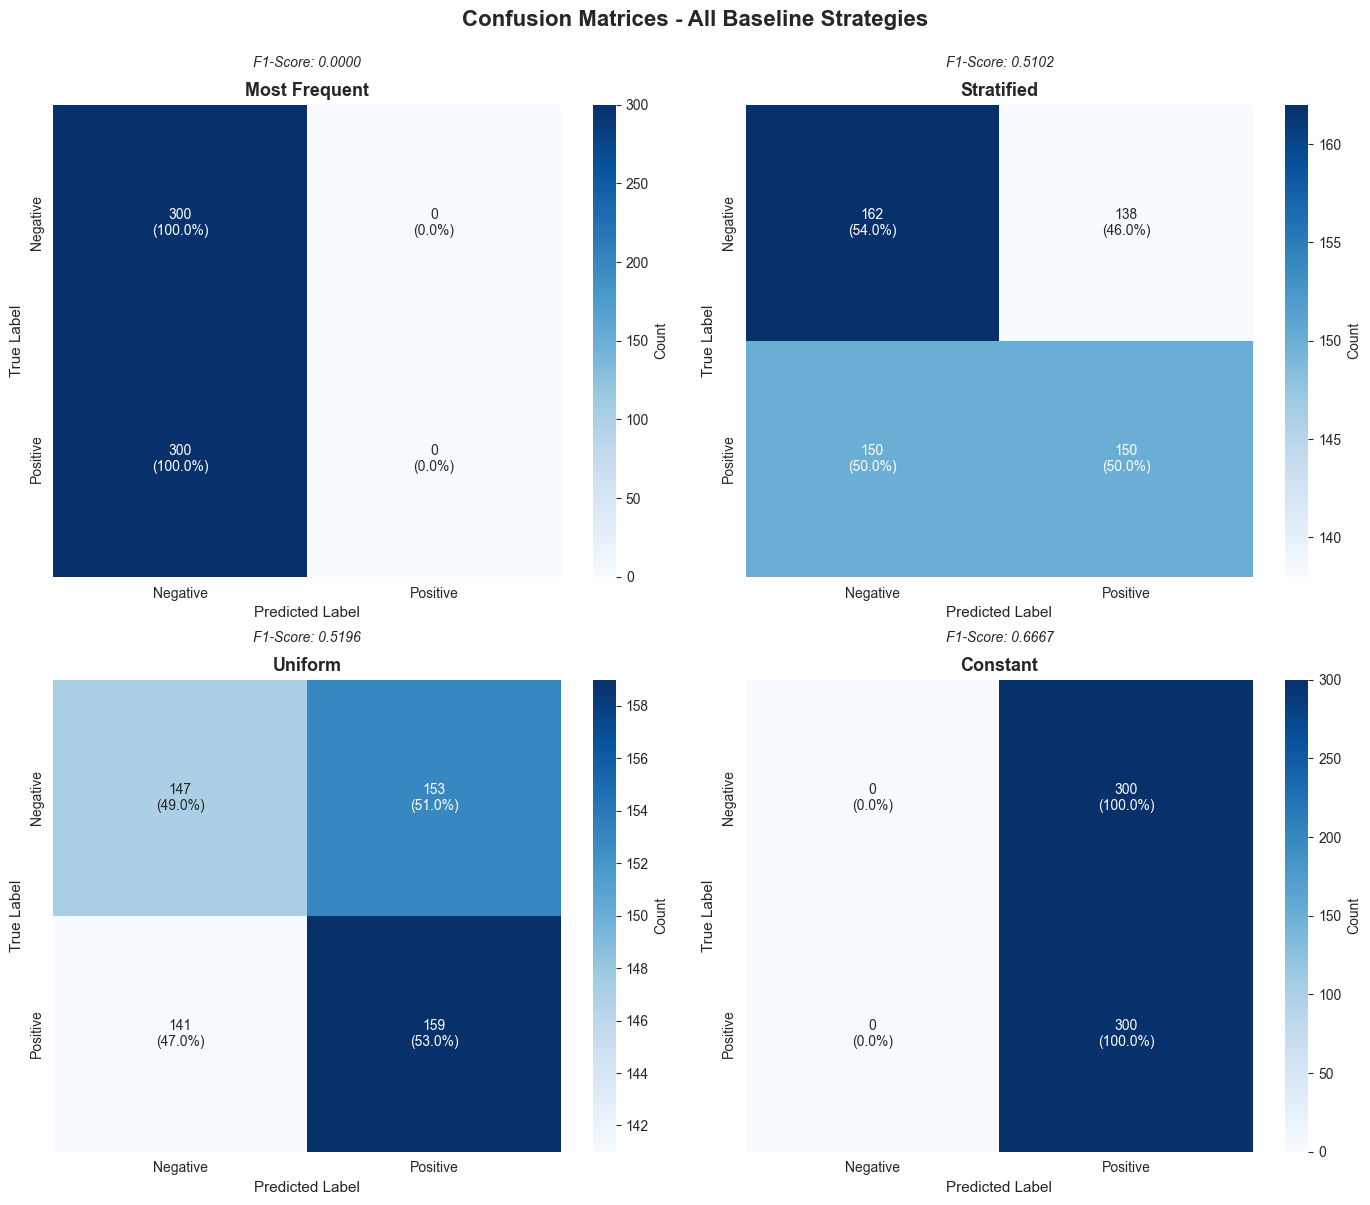

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (model_name, results) in enumerate(baseline_results.items()):
    ax = axes[idx]
    
    cm = results['confusion_matrix']
    
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1%})'
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=ax, cbar=True, 
                cbar_kws={'label': 'Count'})
    
    strategy_name = model_name.replace('Baseline_', '').replace('_', ' ').title()
    ax.set_title(f'{strategy_name}', fontsize=13, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    
    f1 = results['metrics']['f1_score']
    ax.text(0.5, 1.08, f'F1-Score: {f1:.4f}', 
            transform=ax.transAxes,
            ha='center', fontsize=10, style='italic')

plt.suptitle('Confusion Matrices - All Baseline Strategies', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

os.makedirs('../outputs/figures', exist_ok=True)
plt.savefig('../outputs/figures/baseline_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("\n✓ Figure saved: outputs/figures/baseline_confusion_matrices.png")
plt.show()


## 8. Individual Confusion Matrices with Custom Function


Confusion matrix saved to: ../outputs/figures/Baseline_most_frequent_confusion_matrix.png


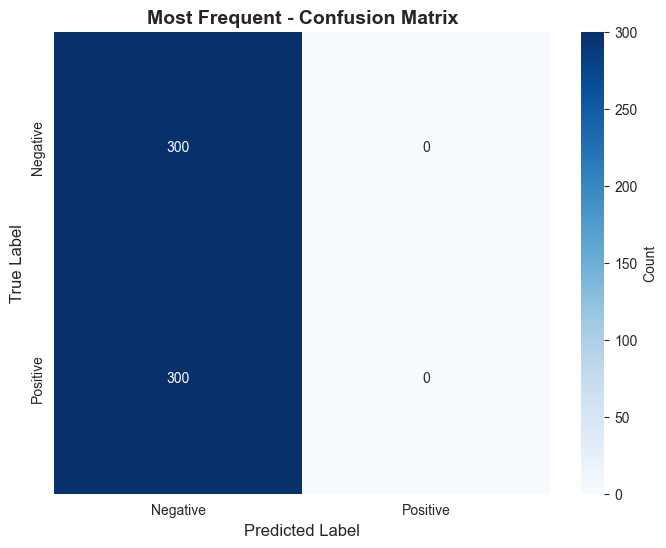

Confusion matrix saved to: ../outputs/figures/Baseline_stratified_confusion_matrix.png


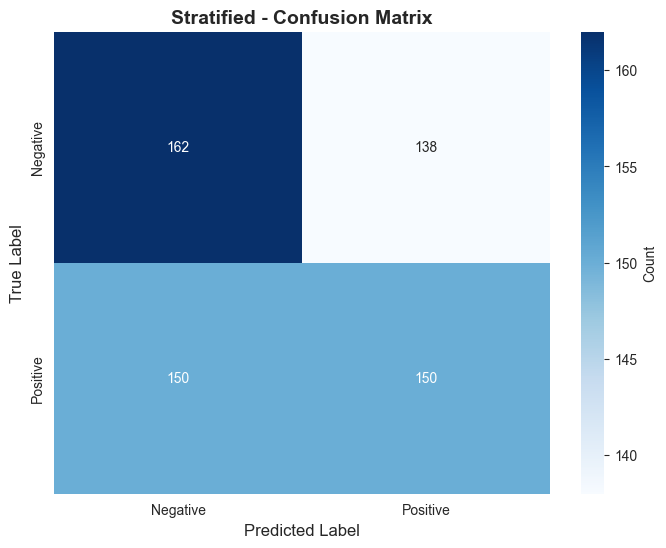

Confusion matrix saved to: ../outputs/figures/Baseline_uniform_confusion_matrix.png


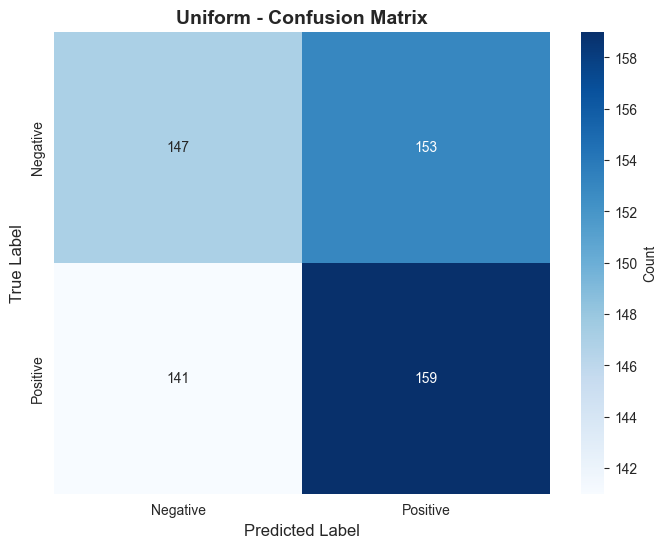

Confusion matrix saved to: ../outputs/figures/Baseline_constant_confusion_matrix.png


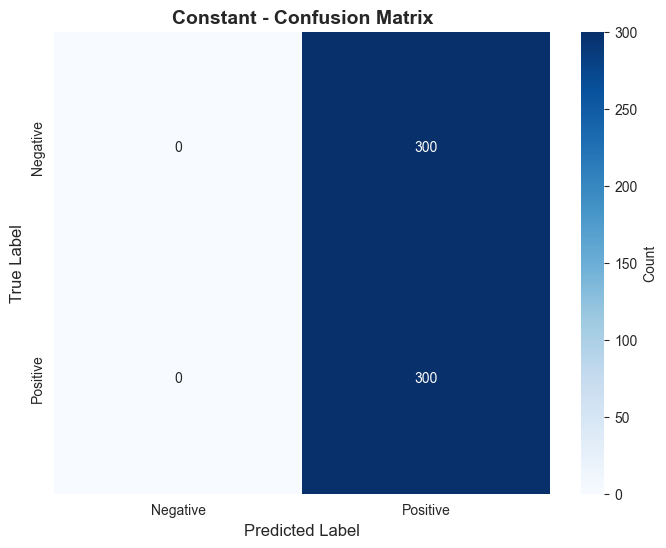

In [10]:
for model_name, results in baseline_results.items():
    strategy_name = model_name.replace('Baseline_', '').replace('_', ' ').title()
    
    plot_confusion_matrix(
        y_test,
        results['y_pred'],
        model_name=strategy_name,
        save_path=f'../outputs/figures/{model_name}_confusion_matrix.png'
    )


## 9. Save All Baseline Results

In [11]:
save_evaluation_results(baseline_results, output_dir='../outputs/metrics')

summary_results = {
    'best_model': best_model_name,
    'best_f1_score': float(best_f1),
    'dataset_info': {
        'train_size': int(len(y_train)),
        'test_size': int(len(y_test)),
        'train_positive': int((y_train == 1).sum()),
        'train_negative': int((y_train == 0).sum()),
        'test_positive': int((y_test == 1).sum()),
        'test_negative': int((y_test == 0).sum()),
        'vocab_size': config['vocab_size'],
        'max_sequence_length': config['max_len']
    },
    'all_models_summary': {
        model_name: {
            k: float(v) if isinstance(v, (np.floating, float)) else v
            for k, v in results['metrics'].items()
        }
        for model_name, results in baseline_results.items()
    }
}

with open('../outputs/metrics/baseline_summary.json', 'w') as f:
    json.dump(summary_results, f, indent=2)

print("\n All baseline results saved successfully")


Results saved for Baseline_most_frequent
Results saved for Baseline_stratified
Results saved for Baseline_uniform
Results saved for Baseline_constant

All results saved to: ../outputs/metrics

 All baseline results saved successfully


## 10. Detailed Analysis of Best Model

In [12]:
best_results = baseline_results[best_model_name]
best_metrics = best_results['metrics']
y_pred_best = best_results['y_pred']
cm_best = best_results['confusion_matrix']

print("BEST BASELINE MODEL - DETAILED ANALYSIS")
print(f"\nBest Model: {best_model_name}")
print(f"\nPerformance Metrics:")
for metric_name, value in best_metrics.items():
    print(f"{metric_name.replace('_', ' ').title():<20s}: {value:.4f}")

print(f"\nConfusion Matrix Analysis:")
tn, fp, fn, tp = cm_best.ravel()
print(f"True Negatives:  {tn:>5d}")
print(f"False Positives: {fp:>5d}")
print(f"False Negatives: {fn:>5d}")
print(f"True Positives:  {tp:>5d}")

print(f"\nError Analysis:")
total_errors = fp + fn
error_rate = total_errors / len(y_test)
print(f"Total Errors:    {total_errors:>5d}")
print(f"Error Rate:      {error_rate:>6.2%}")
print(f"False Pos Rate:  {fp/(fp+tn) if (fp+tn)>0 else 0:>6.2%}")
print(f"False Neg Rate:  {fn/(fn+tp) if (fn+tp)>0 else 0:>6.2%}")


BEST BASELINE MODEL - DETAILED ANALYSIS

Best Model: Baseline_constant

Performance Metrics:
Accuracy            : 0.5000
Precision           : 0.5000
Recall              : 1.0000
F1 Score            : 0.6667
Cohen Kappa         : 0.0000

Confusion Matrix Analysis:
True Negatives:      0
False Positives:   300
False Negatives:     0
True Positives:    300

Error Analysis:
Total Errors:      300
Error Rate:      50.00%
False Pos Rate:  100.00%
False Neg Rate:   0.00%


 ## 11. Conclusions

 ### Key Findings:
 
 1. **Most Frequent Strategy**: 
    - Always predicts the majority class
    - High accuracy if classes are imbalanced, but zero recall for minority class
    - Not useful when both classes are important
 
 2. **Stratified Strategy**: 
    - Respects the class distribution from training data
    - Provides more balanced predictions
    - Generally the best baseline for balanced datasets
 
 3. **Uniform Strategy**: 
    - Predicts uniformly at random (50-50)
    - Typically performs worse than stratified
    - Useful as absolute random baseline
 
 4. **Constant Strategy**:
    - Always predicts a fixed class (positive in our case)
    - Shows what happens with extreme bias
    - High recall but low precision for the predicted class
 
 ### Why DummyClassifier is Important:
 - Provides a **sanity check** for more complex models
 - If neural networks don't beat the baseline, they're not learning anything useful
 - Helps identify class imbalance issues
 - Establishes minimum acceptable performance
 
 ### Baseline Threshold:
 The baseline model establishes a minimum performance threshold that more 
 sophisticated models (Dense NN, RNN, LSTM) should significantly exceed.
 
 ### Expected Improvements:
 - Neural networks should achieve **at least 10-15% improvement** in F1-score
 - Better balance between precision and recall
 - Higher Cohen's Kappa indicating better agreement beyond chance
 - Should learn meaningful patterns from the sequential text data

In [13]:
print("BASELINE MODEL EVALUATION COMPLETE")
print(f"\n Best Baseline Model: {best_model_name}")
print(f" Best F1-Score: {best_metrics['f1_score']:.4f}")
print(f" Best Accuracy: {best_metrics['accuracy']:.4f}")
print(f"\n Target for Neural Models:")
print(f"   - F1-Score should exceed: {best_metrics['f1_score'] + 0.15:.4f}")
print(f"   - Accuracy should exceed: {best_metrics['accuracy'] + 0.10:.4f}")
print(f"   - Cohen's Kappa should exceed: {best_metrics['cohen_kappa'] + 0.20:.4f}")
print("\n Note: DummyClassifier ignores input features and only uses label distribution.")
print("   This is why it's a true baseline - it doesn't learn from the text data!")


BASELINE MODEL EVALUATION COMPLETE

 Best Baseline Model: Baseline_constant
 Best F1-Score: 0.6667
 Best Accuracy: 0.5000

 Target for Neural Models:
   - F1-Score should exceed: 0.8167
   - Accuracy should exceed: 0.6000
   - Cohen's Kappa should exceed: 0.2000

 Note: DummyClassifier ignores input features and only uses label distribution.
   This is why it's a true baseline - it doesn't learn from the text data!
